<div align="center">
<h1><img width="30" src="https://madewithml.com/static/images/rounded_logo.png">&nbsp;<a href="https://madewithml.com/">Made With ML</a></h1>
    <h3>ML for Developers</h3>
    Design · Develop · Deploy · Iterate
</div>

<!-- <br>

<div align="center">
    <a target="_blank" href="https://madewithml.com"><img src="https://img.shields.io/badge/Subscribe-40K-brightgreen"></a>&nbsp;
    <a target="_blank" href="https://github.com/agusabdulrahman/made-with-ml"><img src="https://img.shields.io/github/stars/GokuMohandas/MadeWithML.svg?style=social&label=Star"></a>&nbsp;
    <a target="_blank" href="https://www.linkedin.com/in/agusabdulrahman"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
    <a target="_blank" href="https://twitter.com/agusahn"><img src="https://img.shields.io/twitter/follow/GokuMohandas.svg?label=Follow&style=social"></a>
    <br>
    🔥&nbsp; Among the <a href="https://github.com/agusabdulrahman/made-with-ml" target="_blank">top ML</a> repositories on GitHub
</div>

<br>
<hr> -->

This notebooks contains the code for the 🔢&nbsp; Data and 📈&nbsp; Modeling lessons. After this proof of concept (PoC), we'll be moving all of this code to Python scripts to serve our application to production. Follow the accompanying [lessons](https://madewithml.com/) along with the code here to develop a deeper understanding of all the concepts.

<div align="left">
<a target="_blank" href="https://madewithml.com/"><img src="https://img.shields.io/badge/📖 Read-lessons-9cf"></a>&nbsp;
<a href="https://github.com/agusabdulrahman/Made-With-ML/blob/main/notebooks/madewithml.ipynb" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/agusabdulrahman/Made-With-ML/blob/main/notebooks/madewithml.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# 🛠️ Setup

We'll be using Ray to develop our application using distributed workloads.

In [ ]:
import os
import ray

: 

In [ ]:
import sys; sys.path.append("..")



: 

In [ ]:
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2


: 

In [ ]:
# initial Ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

: 

In [ ]:
ray.cluster_resources()

: 

These cluster resources only reflect our head node ([m5.2xlarge](https://instances.vantage.sh/aws/ec2/m5.2xlarge)). But recall in our [setup lesson](https://madewithml.com/courses/mlops/setup/) that our [compute configuration](https://madewithml.com/courses/mlops/setup/#compute) that we also added [g4dn.xlarge](https://instances.vantage.sh/aws/ec2/g4dn.xlarge) worker nodes (each has 1 GPU and 4 CPU) to our cluster. But because we set `min_workers=0`, our worker nodes will autoscale ( up to `max_workers`) as they're needed for specific workloads (ex. training). 

If you are running this on local laptop (no GPU), use the CPU count from `ray.cluster_resources` to set your resources. For example if you machine has 10 CPUs:

```python
num_worker =  6 # prefer to do a few less then total avaibel CPU (a for head note + 1 for backroudn tasks)
resources_per_worker={"CPU": 1, "GPU": 0}

```

In [ ]:
# Worker (1 g4dn.xlarge)
num_workers =1 
resources_per_worker={"CPU": 1, "GPU": 0}

: 

In [ ]:
from dotenv import load_dotenv
load_dotenv()


: 

In [ ]:
# Storage
EFS_DIR = f"/efs/shared_storage/madewithml/{os.environ['GITHUB_USERNAME']}"
print(EFS_DIR)

: 

# Data

## 🔢 Data ingestion

In [ ]:
import pandas as pd

: 

In [ ]:
# Data ingestion
DATASET_LOC = "https://raw.githubusercontent.com/agusabdulrahman/Made-With-ML/main/datasets/dataset.csv"
df = pd.read_csv(DATASET_LOC)
df.head()

: 

## ✂️ Data splitting

In [ ]:
from sklearn.model_selection import train_test_split

: 

In [ ]:
# Value counts
df.tag.value_counts()

: 

In [ ]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(df, stratify=df.tag, test_size=test_size, random_state=1234)

: 

In [ ]:
# Train value counts
train_df.tag.value_counts()

: 

In [ ]:
# Validation (adjusted) value counts
val_df.tag.value_counts() * int((1-test_size)/test_size)

: 

## 🔍 Exploratory Data Analysis (EDA)

Exporatory data analysis to understand the signals and nuaces of our dataset. It's a cyclical proces that can be done at various points of our development process (before/after labeling, processing, etc). depending on how well the problem is defined.

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

: 

In [ ]:
# Most common tags
all_tags = Counter(df.tag)
all_tags.most_common()

: 

In [ ]:
# Plot tag frequencies
tags, tag_counts = zip(*all_tags.most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
ax.set_xticklabels(tags, rotation=0, fontsize=12)
plt.title("Tas distribution", fontsize=16)
plt.ylabel("# of projects", fontsize=14)
plt.show()

: 

> We'll address the [data imbalance](https://madewithml.com/courses/mlops/baselines#data-imbalance) after splitting into our train split and prior to training our model.

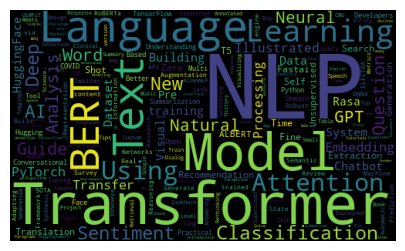

In [56]:
# Most frequent tokens for each tag
tag="natural-language-processing"
plt.figure(figsize=(10, 3))
subset = df[df.tag==tag]
text = subset.title.values
cloud = WordCloud(
    stopwords=STOPWORDS, background_color="black", collocations=False,
    width=500, height=300
).generate(" ".join(text))
plt.axis("off")
plt.imshow(cloud)

Looks like `title` text feature has some good signal for the respentive classes and matches our intuition. We can repeat this for the `description` text features as well. this information will become useful when we decide how to use our features for modeling.

## ✨ Data Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we [split](https://madewithml.com/courses/mlops/splitting) the data first before preprocessing to avoid data leaks.

In [ ]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re



### Feature engineering

We can combine existing input feeatures to create new meaningful signal (helping the model)

In [ ]:
# Feature engineering
df["text"] = df.title + " " + df.description

### Clean text


In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")

In [ ]:
df clean_text(text, stopwords=STOPWORDS):
    # Lower